In [9]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from util import calc_binary_log_odds_from_log_proba, calc_log_odds_from_log_proba
%matplotlib inline

In [10]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)

### Differences of predicted labels

First, let's see to what extent the predicted labels are different:

In [11]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
proba_diff = binary_diff_clf.predict_proba(X)[:, 0]

In [12]:
np.sum(is_pred_equal)

32113

In [13]:
is_pred_diff = ~is_pred_equal
np.sum(is_pred_diff)

448

Let's investigate the predicted labels in more detail, using adapted classical tools for classification evaluation:

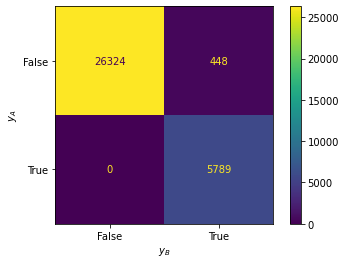

In [14]:
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
cm = confusion_matrix(pred_a, pred_b, labels=binary_diff_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_diff_clf.classes_)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_ylabel('$y_A$')
ax.set_xlabel('$y_B$')
plt.show()

For 206 instances, A predicts True and B False, whereas A never predicts False when B predicts True.

What are the predicted probabilities for these instances?

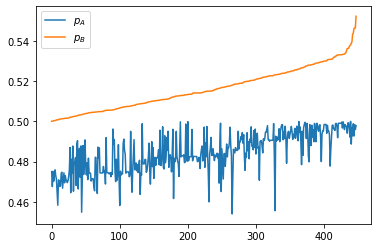

In [15]:
proba_a = clf_a.predict_proba(X)[:, 1]
proba_b = clf_b.predict_proba(X)[:, 1]
order = np.argsort(proba_b[is_pred_diff])
plt.plot(proba_a[is_pred_diff][order], label='$p_A$')
plt.plot(proba_b[is_pred_diff][order], label='$p_B$')
plt.legend();

And in margin space (log-odds probabilities):

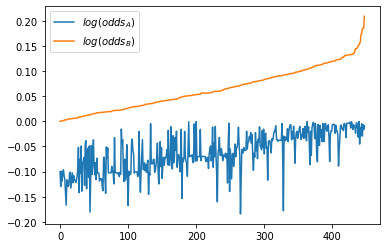

In [16]:
log_odds_a = calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
log_odds_b = calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))
order = np.argsort(log_odds_b[is_pred_diff])
plt.plot(log_odds_a[is_pred_diff][order], label='$log(odds_A)$')
plt.plot(log_odds_b[is_pred_diff][order], label='$log(odds_B)$')
plt.legend();

### Differences of probabilities

In [17]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
pred = diff_clf.predict(X)
proba = diff_clf.predict_proba(X)

Let's check the distributions of the probabilities for each class:

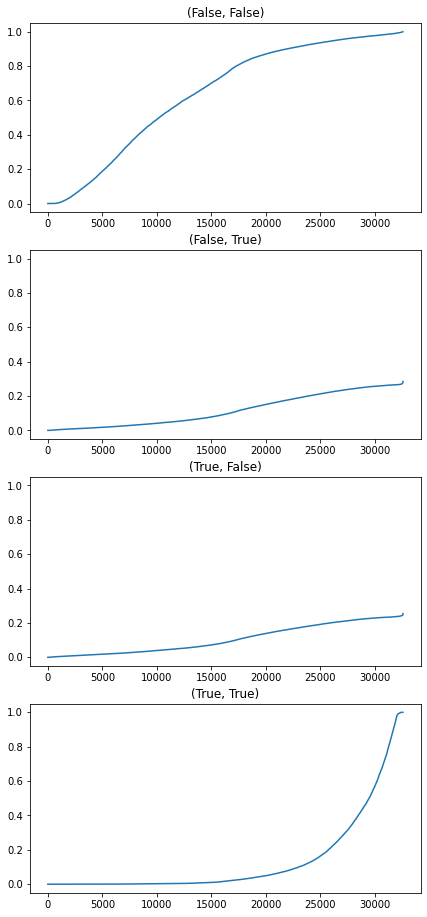

In [18]:
nrows = len(diff_clf.classes_)
ncols = 1
fig = plt.figure(figsize=(7, nrows*4))
ax_ref = None
for plot_idx, (class_proba, class_tuple) in enumerate(zip(proba.T, diff_clf.class_tuples), 1):
    ax = fig.add_subplot(nrows, ncols, plot_idx, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    ax.plot(np.sort(class_proba), label=str(class_tuple))
    ax.set_title(str(class_tuple))

Scatter plot of the probabilities for the difference classes, with a color for each class:

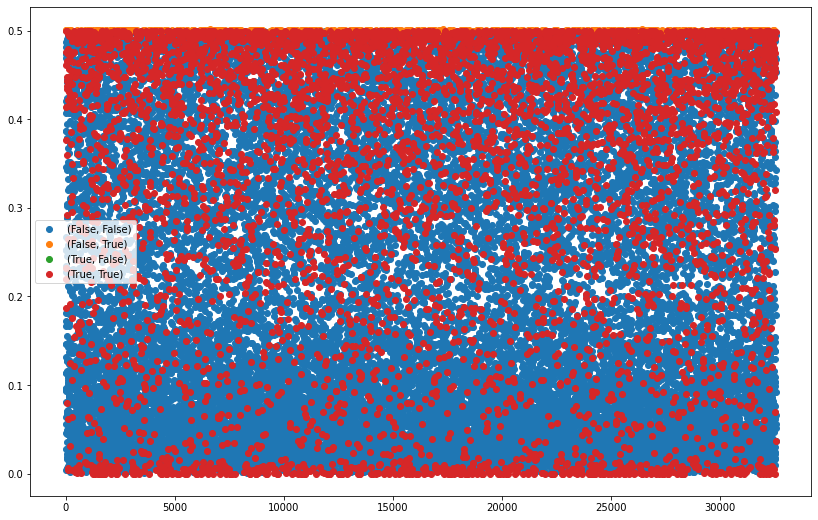

In [19]:
indices = np.indices(y.shape).ravel()
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], proba_diff[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

Euclidian distance between pairs of probabilities $|p_B - p_A|$:

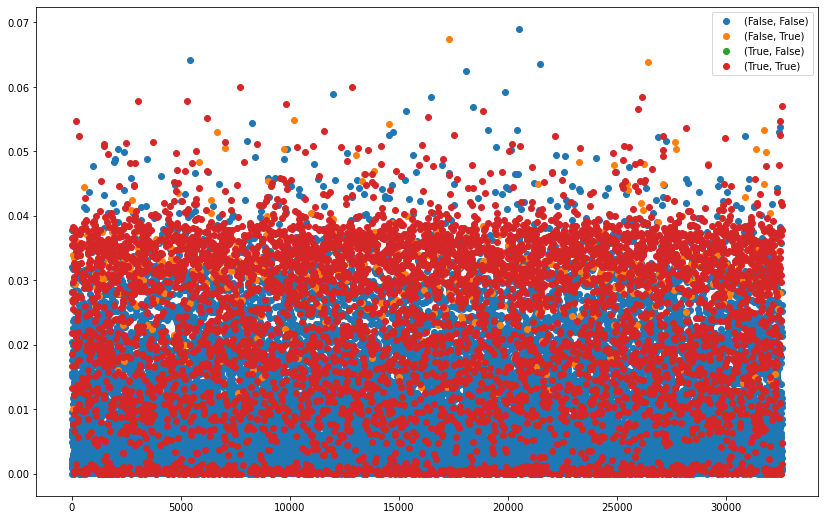

In [20]:
euclid_dist = np.abs(proba_b - proba_a)
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], euclid_dist[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

And further subtractions:

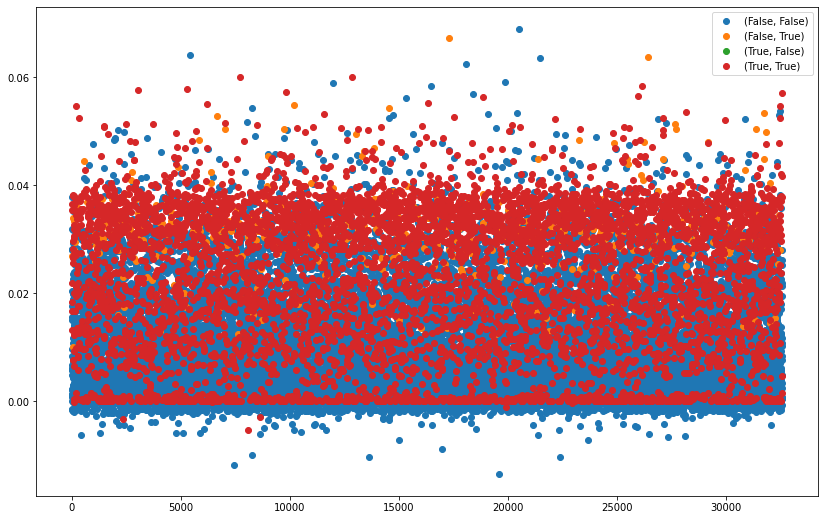

In [21]:
diff = proba_b - proba_a
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], diff[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

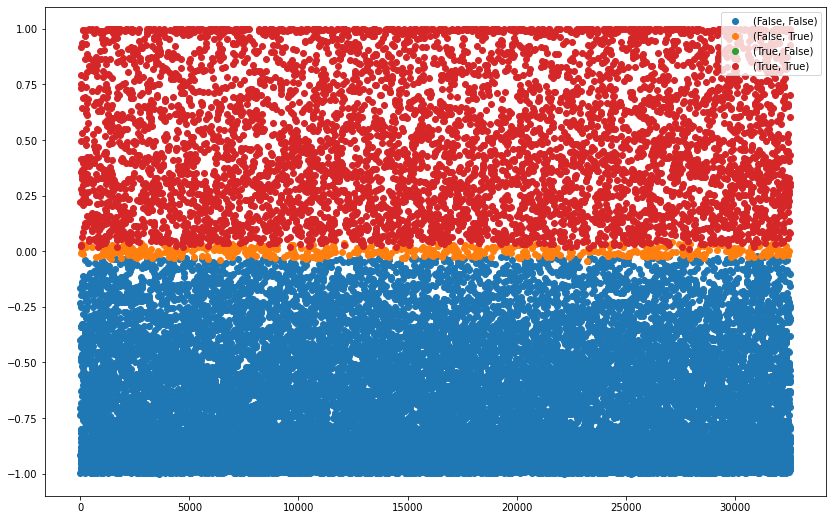

In [22]:
diff2 = proba_b - (1 - proba_a)
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], diff2[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

[Here](https://en.wikipedia.org/wiki/Metric_space#Examples_of_metric_spaces) is another distance function proposed $|log(\frac{p_B}{p_A})|$ that forms a complete metric space for real positive numbers

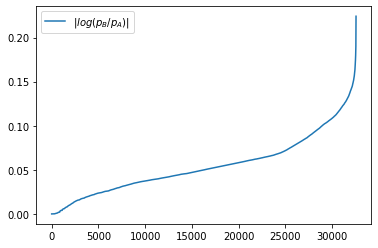

In [23]:
log_proba_ratio = np.abs(np.log(proba_b/proba_a))
plt.plot(sorted(log_proba_ratio), label='$|log(p_B/p_A)|$')
plt.legend();

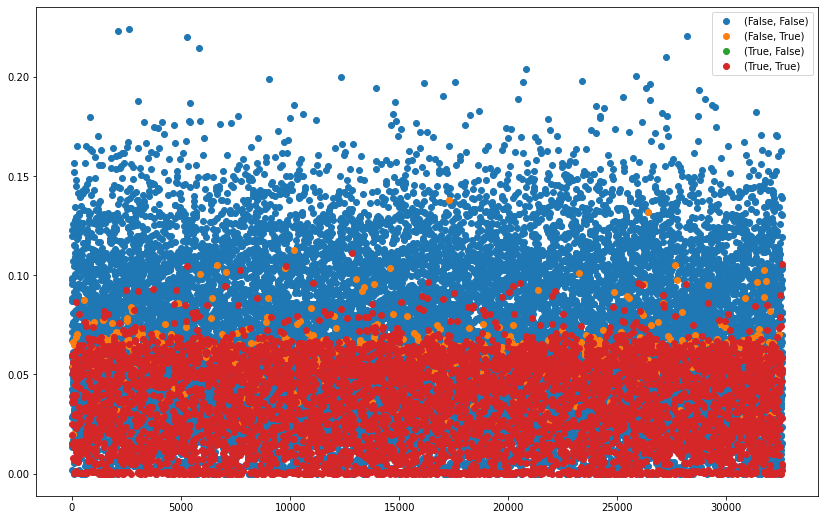

In [24]:
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], log_proba_ratio[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

### Differences of log odds
Now let's see how that looks like in margin space

In [25]:
log_odds_equal = calc_binary_log_odds_from_log_proba(binary_diff_clf.predict_log_proba(X))
log_odds = calc_log_odds_from_log_proba(diff_clf.predict_log_proba(X))

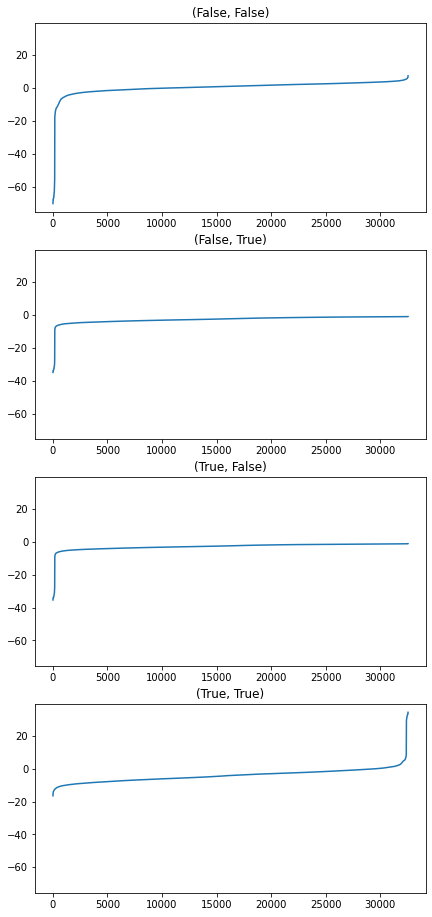

In [26]:
nrows = len(diff_clf.classes_)
ncols = 1
fig = plt.figure(figsize=(7, nrows*4))
ax_ref = None
for plot_idx, (class_log_odds, class_tuple) in enumerate(zip(log_odds.T, diff_clf.class_tuples), 1):
    ax = fig.add_subplot(nrows, ncols, plot_idx, sharey=ax_ref)
    if not ax_ref:
        ax_ref = ax
    ax.plot(np.sort(class_log_odds), label=str(class_tuple))
    ax.set_title(str(class_tuple))

Scatter plot of the log-odds for the difference classes, with a color for each class:

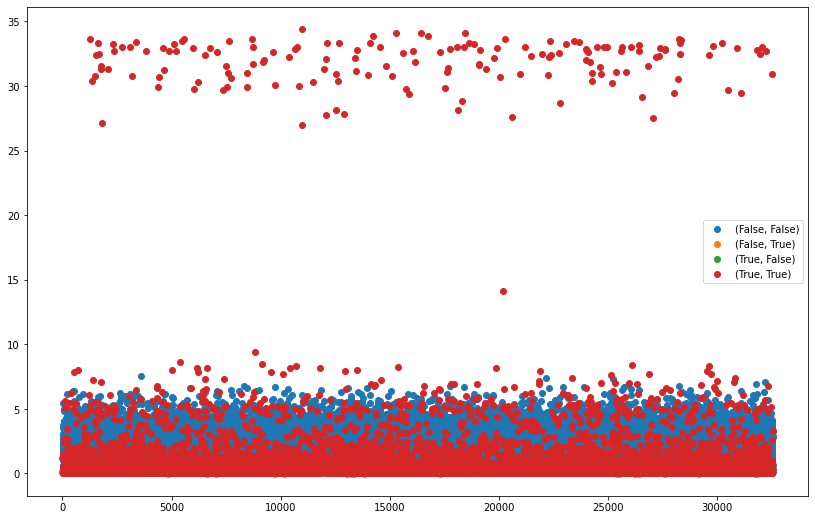

In [27]:
indices = np.indices(y.shape).ravel()
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], log_odds_equal[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

Euclidian distance between pairs of log-odds $|log(odds(B) - log(odds(A))|$:

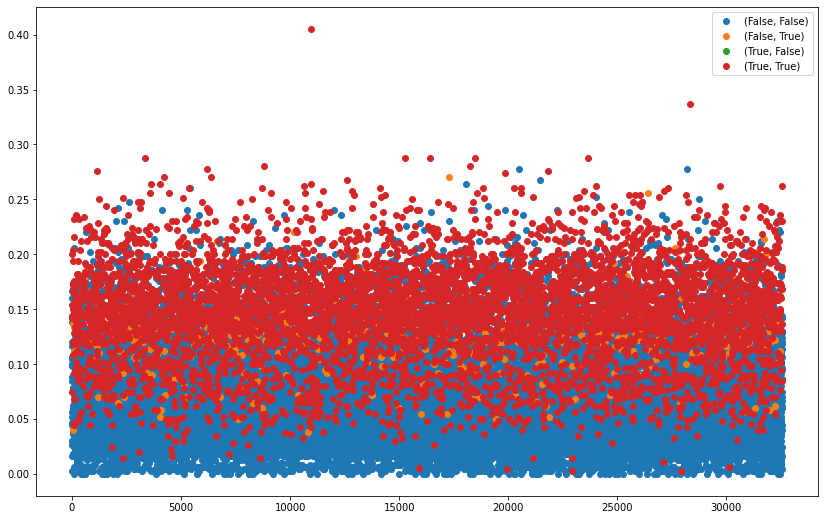

In [28]:
euclid_dist = np.abs(log_odds_b - log_odds_a)
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], euclid_dist[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()

Log-odds-ratio

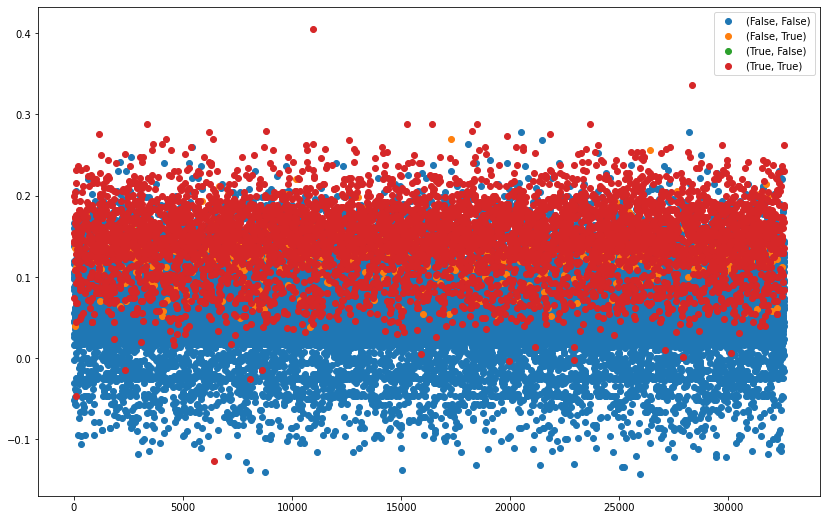

In [29]:
log_odds_ratio = log_odds_b - log_odds_a
fig, ax = plt.subplots(figsize=(14, 9))
for class_ in diff_clf.classes_:
    mask = pred == class_
    ax.scatter(indices[mask], log_odds_ratio[mask], label=str(diff_clf.class_tuples[class_]))
ax.legend()
plt.show()